# Imports

In [718]:
import pandas as pd
import numpy as np
import os, sys, math, time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime

from sklearn.model_selection import train_test_split

In [ ]:
def missing (df):
    missing_number = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1,
                               keys=['Missing_Number', 'Missing_Percent'])
    return missing_values

missing(df)

# Pandas

## Basic manipulations / operations

In [21]:
df = pd.DataFrame(np.arange(12).reshape(3, 4), columns=['A', 'B', 'C', 'D'])
df

,A,B,C,D
0,0,1,2,3
1,4,5,6,7
2,8,9,10,11


### Index

In [87]:
df = pd.DataFrame(np.arange(12).reshape(3, 4), columns=['A', 'B', 'C', 'D'])
# datetime, timedelta
dt = np.repeat(np.datetime64('2023-01-01T00:00:00'), len(df)) \
        + np.array([0,0,1]) * np.timedelta64(1, 'D')
# set_index
df.set_index([df.index.rename('row'), pd.Series(dt, name='dt')], inplace = True)
# get index level values
print(df.index.get_level_values(level=1))
# reorder index
df = df.reorder_levels(['dt', 'row'])
df

DatetimeIndex(['2023-01-01', '2023-01-01', '2023-01-02'], dtype='datetime64[s]', name='dt', freq=None)


A  B   C   D
dt         row              
2023-01-01 0    0  1   2   3
           1    4  5   6   7
2023-01-02 2    8  9  10  11

In [88]:
# drop index level
df.droplevel(level=0, axis=0)

,A,B,C,D
row,,,,
0,0,1,2,3
1,4,5,6,7
2,8,9,10,11


### Columns

**rename cols**

In [62]:
df.rename({'D':'col_D'}, axis=1)

A  B   C  col_D
dt         row                 
2023-01-01 0    0  1   2      3
           1    4  5   6      7
2023-01-02 2    8  9  10     11

**drop col**

In [63]:
df.drop(['A'], axis=1, inplace=False)

B   C   D
dt         row           
2023-01-01 0    1   2   3
           1    5   6   7
2023-01-02 2    9  10  11

**drop rows**

In [69]:
df.drop([pd.to_datetime('2023-01-01')], axis=0, inplace=False)

,,A,B,C,D
dt,row,,,,
2023-01-02,2,8,9,10,11


### Missing Values

**get missing value counts**

In [76]:
df['E'] = np.array([1.0, np.nan, 0.5])
#rint(np.isnan(df['E']))
df.isnull().sum().sort_values(ascending=False)

E    1
A    0
B    0
C    0
D    0
dtype: int64

**fill missing values**

In [78]:
# can use on df or Series
df.fillna(0.)
df['E'].fillna(0.)

dt          row
2023-01-01  0      1.0
            1      0.0
2023-01-02  2      0.5
Name: E, dtype: float64

# numpy

**random sample**

In [86]:
np.random.choice(np.arange(3), size=(10,), replace=True, p=[.2,.2,.6])

array([0, 2, 1, 2, 1, 1, 2, 2, 2, 2])

In [96]:
np.random.normal(loc=1, scale=1, size=(10,))

array([1.98499189, 0.33541042, 1.56870114, 0.06085436, 1.22979076,
       1.36830166, 1.89503128, 0.5321554 , 2.02759013, 1.16371085])

**linreg**

In [ ]:
coef, SSR, rank, SVs = np.linalg.lstsq(X, y, rcond=None)

**reshape / resize**

In [130]:
a = np.arange(10, dtype=np.int8)
#a = np.arange(10, dtype=np.float64)
print(a.shape)
print(a.reshape(1,-1).shape)
print(a.reshape(-1,1).shape)

(10,)
(1, 10)
(10, 1)


In [131]:
print(np.expand_dims(a, axis=0).shape)
print(np.expand_dims(a, axis=1).shape)

(1, 10)
(10, 1)


In [143]:
#b = np.empty_like(a)
b = np.repeat(1,10)
np.vstack([a,b]).T
#np.hstack([a.reshape(-1,1),b.reshape(-1,1)])

array([[0, 1],
       [1, 1],
       [2, 1],
       [3, 1],
       [4, 1],
       [5, 1],
       [6, 1],
       [7, 1],
       [8, 1],
       [9, 1]])

# scipy

**cdist, pdist**

In [ ]:
from scipy.spatial.distance import cdist, pdist, squareform
#pdist_default = pdist(df_fraud[cols], metric='euclidean')
#W = squareform(Y)

**norm**

In [94]:
from scipy.stats import norm
norm.cdf([0,2])

array([0.5       , 0.97724987])

# Plotting (matplotlib)

# Feature Selection

**discrete, binary target**

In [217]:
from sklearn.feature_selection import f_classif, mutual_info_classif

MI_classif_scores = mutual_info_classif(X, target)
f_classif_scores = f_classif(X, target)

f_classif_scores

(array([0.08232162, 0.25562039]), array([0.77418148, 0.61315625]))

In [220]:
target

array([0, 1, 0, ..., 0, 1, 1])

In [218]:
mutual_info_classif(X, target)

array([0, 0])

# Linear Model / Regression

# Classification

In [214]:
from sklearn.metrics import roc_auc_score

def gini_impurity(x):
    _, counts = np.unique(x, return_counts=True)
    return 0 if len(x) == 0 else 1 - np.sum(np.square(counts)) / len(x) ** 2

def entropy_impurity(x):
    _, counts = np.unique(x, return_counts=True)
    return 0 if len(x) == 0 else np.log(len(x)) - np.sum(counts * np.log(counts)) / len(x)

def tpr(threshold, y_true, y_score):
    cond = y_score > threshold
    return sum(y_true[cond]) / sum(y_true)

def fpr(threshold, y_true, y_score):
    cond = y_score > threshold
    return sum(1 - y_true[cond]) / sum(1 - y_true)

def tpr_fpr(threshold, y_true, y_score):
    cond = y_score > threshold
    return sum(y_true[cond]) / sum(y_true), sum(1 - y_true[cond]) / sum(1 - y_true)

**generate some data**

In [692]:
#n = int(1e4)
n = 10000
p0 = .5
target = np.random.choice(2, n, p=[p0, 1-p0])
x_var1 = 2 * target + np.random.normal(0,2,n)
x_var2 = target + np.random.normal(0,1,n)
x_var3 = np.where(target==0, np.random.choice([-10,10],n,p=[.6,.4]) + np.random.normal(0,3,n), np.random.normal(-5,3,n))
print(min(x_var3), max(x_var3))
X = np.vstack([x_var1, x_var2, x_var3]).T
x_var4 = np.abs(x_var3)
X_wAbsV3 = np.vstack([x_var1, x_var2, x_var3, x_var4]).T

X_train, X_test, X2_train, X2_test, y_train, y_test = train_test_split(X, X_wAbsV3, target,
                                                                       test_size=0.25, stratify=target, random_state=0)

-21.837175469017893 20.817772447982428


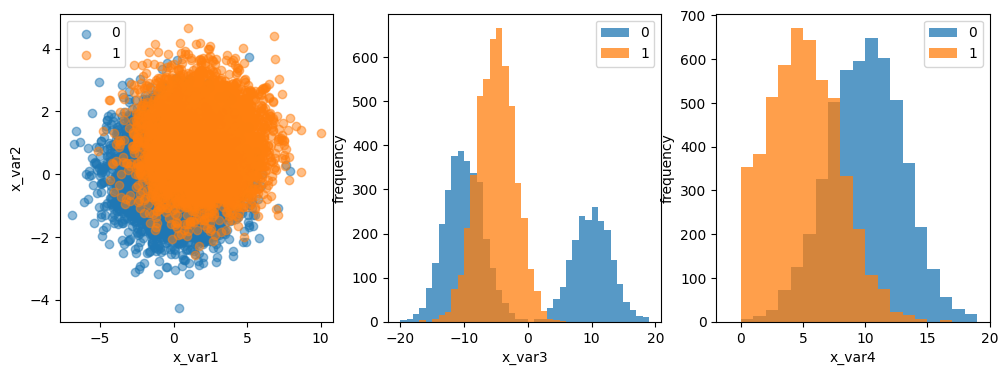

In [694]:
_, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

for val in [0,1]:
    idx = np.where(target==val)[0]
    ax1.scatter(x_var1[idx], x_var2[idx], label = f'{val}', alpha=.5)
    ax2.hist(x_var3[idx], label = f'{val}', alpha=.75, bins=np.arange(-20,20,1))
    ax3.hist(x_var4[idx], label = f'{val}', alpha=.75, bins=np.arange(-1,20,1))

ax1.set_xlabel('x_var1')
ax1.set_ylabel('x_var2')
ax2.set_xlabel('x_var3')
ax2.set_ylabel('frequency')
ax3.set_xlabel('x_var4')
ax3.set_ylabel('frequency')
ax1.legend()
ax2.legend()
ax3.legend()
plt.show()

In [695]:
print(roc_auc_score(target, x_var1))
cond0 = target==0
auc = np.sum(np.subtract.outer(x_var1[~cond0], x_var1[cond0]) > 0)/(np.sum(cond0)*np.sum(~cond0))
print(auc)

0.7559386701454102
0.7559386701454102


## Feature Selection

In [696]:
from sklearn.feature_selection import f_classif, mutual_info_classif

MI_classif_scores = mutual_info_classif(X2_train, y_train)
print(MI_classif_scores)

f_classif_scores = f_classif(X2_train, y_train)
print(f_classif_scores)

[0.1107342  0.11570315 0.35519333 0.26254992]
(array([1822.00686466, 1789.62929615,  245.97427705, 5502.02908581]), array([0.00000000e+00, 0.00000000e+00, 1.43388642e-54, 0.00000000e+00]))


## Logistic Regression
- Excels at extrapolating trends / linear relations
- Can't learn nonlinear interactions

**statsmodels.api**

In [697]:
import statsmodels.api as sm
mod = sm.Logit(y_train, sm.add_constant(X2_train)).fit()
mod.summary()

Optimization terminated successfully.
         Current function value: 0.250201
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 7500
Model:                          Logit   Df Residuals:                     7495
Method:                           MLE   Df Model:                            4
Date:                Sun, 11 Feb 2024   Pseudo R-squ.:                  0.6390
Time:                        15:03:50   Log-Likelihood:                -1876.5
converged:                       True   LL-Null:                       -5198.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.8297      0.130     29.413      0.000       3.575       4.085
x1             0.4902      0.022     22.013      0.000       0.447       0.534
x2             0.9454      0.044     21.591      0.000       0.860       1.031
x3            -0.5403      0.040    -13.454      0.000      -0.619      -0.462
x4            -1.1083      0.047    -23.516      0.000      -1.201      -1.016
==============================================================================

Possibly complete quasi-separation: A fraction 0.15 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

**sklearn**

In [698]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve

# without abs(x_var3)
clf1 = LogisticRegression().fit(X_train, y_train)
print(clf1.intercept_, clf1.coef_)
# with abs(x_var3)
clf2 = LogisticRegression().fit(X2_train, y_train)
print(clf2.intercept_, clf2.coef_)

[-1.13888855] [[ 0.48756373  0.95356973 -0.04754905]]
[3.82489573] [[ 0.48965358  0.94305263 -0.53726206 -1.10453652]]


In [699]:
# get predicted probabilities of target==1
pred_probs1 = clf1.predict_proba(X_test)[:,1]
print(roc_auc_score(y_test, pred_probs1))

0.8497380144909634


In [700]:
# get binary prediction
pred = clf2.predict(X2_test)
# get predicted probabilities of target==1
pred_probs2 = clf2.predict_proba(X2_test)[:,1]
print(roc_auc_score(y_test, pred_probs2))

0.961148576215799


## Decision Tree

In [342]:
from sklearn import tree
from sklearn.inspection import permutation_importance

In [ ]:
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

In [701]:
clf = tree.DecisionTreeClassifier(max_depth=4, class_weight='balanced',
                                  min_weight_fraction_leaf=.05)
clf = clf.fit(X_train, y_train)
pred_probs_DTC = clf.predict_proba(X_test)[:,1]
print(roc_auc_score(y_test, pred_probs_DTC))

0.928549348444247


## LightGBM
- Excels at learning nonlinear interactions
- Can't extrapolate

In [788]:
import lightgbm as lgb
params = {
    'objective': 'binary',
    #'boosting_type': 'rf',
    'boosting_type': 'gbdt',
    'num_leaves': 6, #main parameter to control the complexity of the tree model
    #'max_depth': 3,
    'learning_rate': 0.1,
    #'colsample_bytree': .5, #feature_fraction
    #'n_iter':20
    'subsample_freq':1, #bagging_freq
    'subsample':.9, #bagging_fraction
    'min_child_samples':250, #min_data_in_leaf
    #'pos_bagging_fraction':.8,
    #'neg_bagging_fraction':.8,
    #'scale_pos_weight':1 / (np.mean(y_train) * .9)
    'reg_lambda':20.0 #lambda_l2
}
clf_LGBM = lgb.LGBMClassifier(n_estimators=200, **params)
clf_LGBM.fit(X_train, y_train)

pred_probs_LGBM = clf_LGBM.predict_proba(X_test)[:,1]
print(roc_auc_score(y_test, pred_probs_LGBM))

[LightGBM] [Info] Number of positive: 3740, number of negative: 3760
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 7500, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498667 -> initscore=-0.005333
[LightGBM] [Info] Start training from score -0.005333
0.9583123998794233


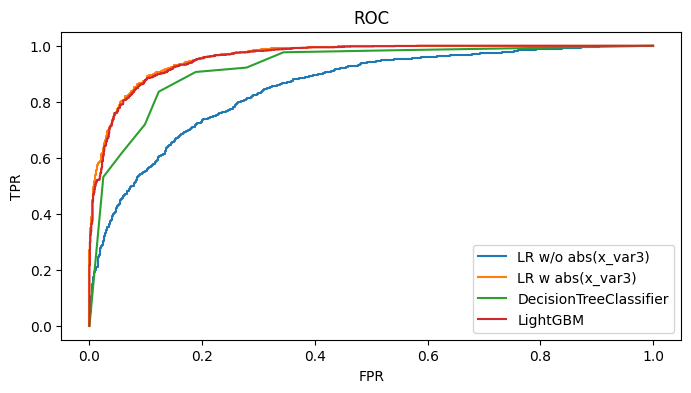

In [789]:
fpr1, tpr1, _ = roc_curve(y_test, pred_probs1)
fpr2, tpr2, _ = roc_curve(y_test, pred_probs2)
fprLGBM, tprLGBM, _ = roc_curve(y_test, pred_probs_LGBM)
fprLGBM, tprLGBM, _ = roc_curve(y_test, pred_probs_LGBM)
plt.figure(figsize=(8,4))
plt.plot(fpr1, tpr1, label='LR w/o abs(x_var3)')
plt.plot(fpr2, tpr2, label='LR w abs(x_var3)')
plt.plot(fprDTC, tprDTC, label='DecisionTreeClassifier')
plt.plot(fprLGBM, tprLGBM, label='LightGBM')
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.title('ROC')
plt.legend()
plt.show()

In [709]:
from sklearn.metrics import auc, precision_recall_curve, average_precision_score
clf = clf2
#pred = clf.predict(X2_test)
p_train = clf2.predict_proba(X2_train)[:,1]
p_test = clf2.predict_proba(X2_test)[:,1]

print('True Positive Rate on training set: %.3f' \
      % (np.mean(clf.predict(X2_train[y_train == 1]) == y_train[y_train == 1])))
print('True Positive Rate on test set: %.3f' \
      % (np.mean(clf.predict(X2_test[y_test == 1]) == y_test[y_test == 1])))

print('True Negative Rate on training set: %.3f' \
      % (np.mean(clf.predict(X2_train[y_train == 0]) == y_train[y_train == 0])))
print('True Negative Rate on test set: %.3f' \
      % (np.mean(clf.predict(X2_test[y_test == 0]) == y_test[y_test == 0])))

print('Area Under ROC Curve (AUC) for train set predicted probabilities: %.3f' \
      % (roc_auc_score(y_train, p_train)))
print('Area Under ROC Curve (AUC) for test set predicted probabilities: %.3f' \
      % (roc_auc_score(y_test, p_test)))

precision, recall, thresholds = precision_recall_curve(y_train, p_train)
print('Area Under the Precision-Recall Curve (AUPRC) for training set predicted probabilities: %.3f' \
      % (auc(recall, precision)))

precision, recall, thresholds = precision_recall_curve(y_test, p_test)
print('Area Under the Precision-Recall Curve (AUPRC) for test set predicted probabilities: %.3f' \
      % (auc(recall, precision)))

True Positive Rate on training set: 0.903
True Positive Rate on test set: 0.897
True Negative Rate on training set: 0.877
True Negative Rate on test set: 0.887
Area Under ROC Curve (AUC) for train set predicted probabilities: 0.961
Area Under ROC Curve (AUC) for test set predicted probabilities: 0.961
Area Under the Precision-Recall Curve (AUPRC) for training set predicted probabilities: 0.956
Area Under the Precision-Recall Curve (AUPRC) for test set predicted probabilities: 0.960


## TensorFlow

# Time Series

- Core components of a time series:
    - **series = trend + seasonality + cycles (autoregressive) + error**
- Build a model by learning the components of a time series in an iterative process:
    1. Learn the trend and subtract it out
    2. Learn the seasonality from the detrended residuals and subtract it out
    3. Fit the autocorrelation (cycles) and subtract it out
    4. Check if only unpredictable error remains in the residuals
    5. Consider modeling the residual series

## Learning the main components -- Tunnel data example

In [764]:
import matplotlib.dates as mdates
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.signal import periodogram
from statsmodels.tsa.deterministic import DeterministicProcess, Fourier
from sklearn.linear_model import LinearRegression

df = pd.read_csv('./tunnel.csv', parse_dates=["Day"])
print(df.shape)
df.head(5)

(747, 2)


,Day,NumVehicles
0,2003-11-01,103536
1,2003-11-02,92051
2,2003-11-03,100795
3,2003-11-04,102352
4,2003-11-05,106569


### Look at data
- Plot series, along with rolling 7-day and 365-day averages across the 2-year period
- Can detect an upward trend in the data and some apparent seasonality
- Weekly seasonality appears particular strong
- There is autocorrelation in the series

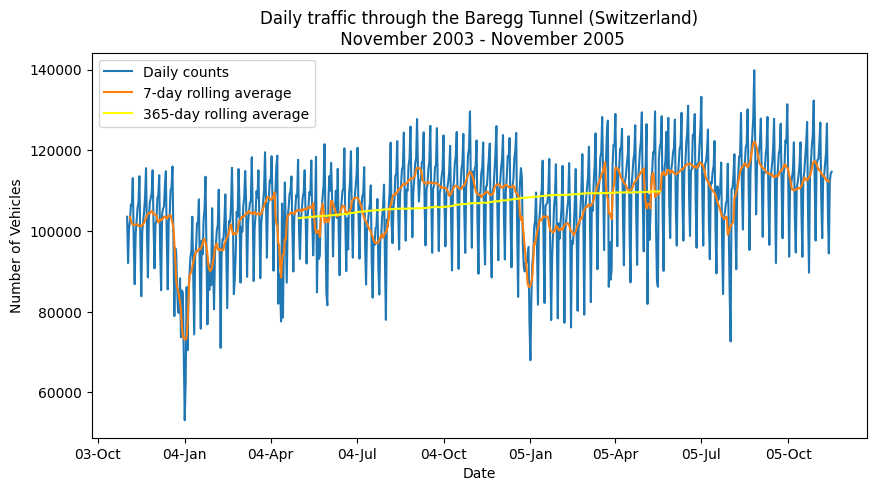

In [758]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.plot(df['Day'],df['NumVehicles'], label='Daily counts')
ax.plot(df['Day'], df['week_avg'], label='7-day rolling average')
ax.plot(df['Day'], df['yr_avg'], label='365-day rolling average', c='yellow')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%y-%b'))
ax.set_xlabel('Date')
ax.set_ylabel('Number of Vehicles')
ax.set_title('Daily traffic through the Baregg Tunnel (Switzerland)\n November 2003 - November 2005')

ax.legend()
plt.show()

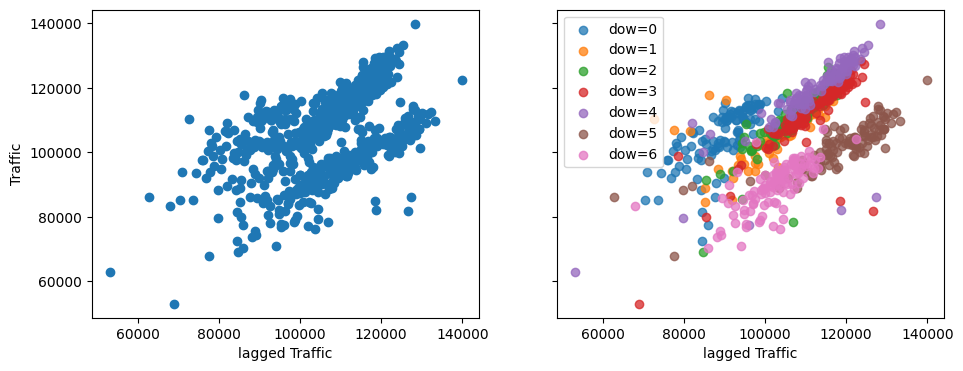

In [735]:
df['lag1'] = df['NumVehicles'].shift(1)
df['dow'] = df["Day"].dt.dayofweek

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(11,4), sharex=True, sharey=True)
ax1.scatter(df['lag1'],df['NumVehicles'])
ax1.set_ylabel('Traffic')
ax1.set_xlabel('lagged Traffic')
for dow in range(7):
    row_ix = np.where(df['dow'] == dow)[0]
    ax2.scatter(df.loc[row_ix, 'lag1'], df.loc[row_ix, 'NumVehicles'], label="dow="+str(dow), alpha = .75)
ax2.legend()
ax2.set_xlabel('lagged Traffic')
plt.show()

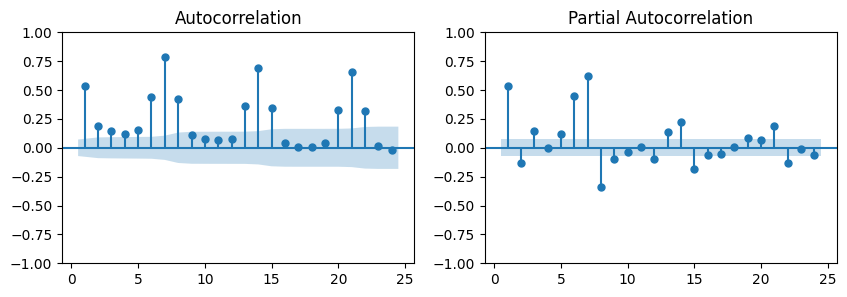

In [739]:
fig, axes = plt.subplots(1, 2, figsize=(10,3))
fig = plot_acf(df['NumVehicles'], lags=24, ax=axes[0], zero=False)
fig = plot_pacf(df['NumVehicles'], lags=24, ax=axes[1], zero=False)
plt.show()

### Compute and interpret periodogram
- Helps fit the seasonality of the data
- Provides an estimate of the power spectral density, the strength of the frequencies in the time series
    - Note: the value on the y-axis of the graph is (a ** 2 + b ** 2) / 2, where a and b are the estimated coefficients of the sine and cosine at that frequency
    - Looking at the periodogram from left to right, the periodogram shows annual and semiannual frequencies, and drops off between the Bimonthly (6) and Monthly (12) frequencies. And then spikes significantly at the weekly frequency.
- Include **10 Fourier feature pairs** to model the annual seasonality.
- The weekly frequency is better modeled with **seasonal indicators** (best for a season with few observations)

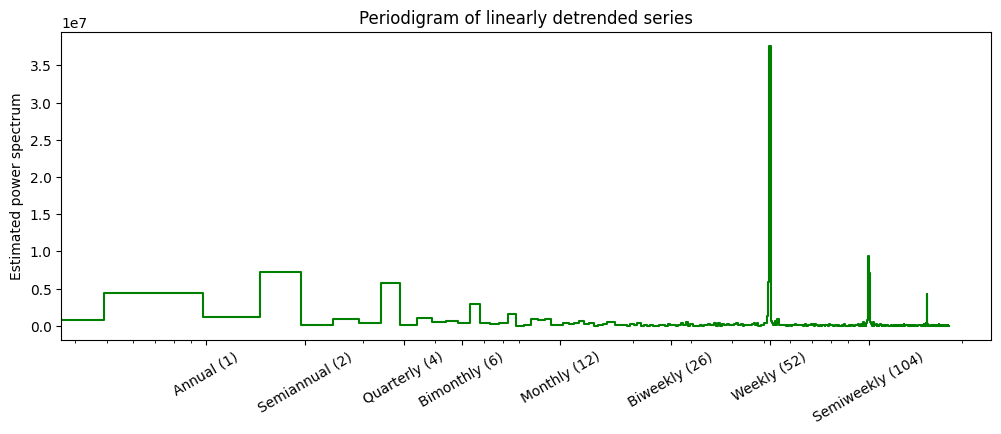

In [756]:
f, Pxx = periodogram(df['NumVehicles'], fs=365.25, window='boxcar', detrend='linear', scaling='spectrum')
fig, ax = plt.subplots(figsize=(12,4))
ax.step(f, Pxx, color="green")
ax.set_xscale("log")
ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
ax.set_xticklabels(
    [
        "Annual (1)",
        "Semiannual (2)",
        "Quarterly (4)",
        "Bimonthly (6)",
        "Monthly (12)",
        "Biweekly (26)",
        "Weekly (52)",
        "Semiweekly (104)",
    ],
    rotation=30,
)
ax.set_ylabel('Estimated power spectrum')
ax.set_title('Periodigram of linearly detrended series')
plt.show()

### Fit linear model with exogenous variables for capturing trend and seasonality
- Look for structure in the residuals of the fitted values

In [793]:
fourier_gen = Fourier(365.25, order=10)
det_proc = DeterministicProcess(df.index, constant=True, order=1, period=7, seasonal=True, additional_terms=[fourier_gen])
det_proc.in_sample().head(10)

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,365.25)","cos(1,365.25)",...,"sin(6,365.25)","cos(6,365.25)","sin(7,365.25)","cos(7,365.25)","sin(8,365.25)","cos(8,365.25)","sin(9,365.25)","cos(9,365.25)","sin(10,365.25)","cos(10,365.25)"
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
1,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.017202,0.999852,...,0.103031,0.994678,0.120126,0.992759,0.137185,0.990545,0.154204,0.988039,0.171177,0.985240
2,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.034398,0.999408,...,0.204966,0.978769,0.238513,0.971139,0.271777,0.962360,0.304719,0.952442,0.337301,0.941397
3,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.051584,0.998669,...,0.304719,0.952442,0.353445,0.935455,0.401229,0.915978,0.447945,0.894061,0.493468,0.869764
4,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.068755,0.997634,...,0.401229,0.915978,0.463258,0.886224,0.523094,0.852275,0.580455,0.814292,0.635068,0.772456
5,1.0,6.0,0.0,0.0,0.0,0.0,1.0,0.0,0.085906,0.996303,...,0.493468,0.869764,0.566362,0.824157,0.635068,0.772456,0.699079,0.715044,0.757922,0.652346
6,1.0,7.0,0.0,0.0,0.0,0.0,0.0,1.0,0.103031,0.994678,...,0.580455,0.814292,0.661263,0.750154,0.735034,0.678031,0.800980,0.598691,0.858402,0.512978
7,1.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.120126,0.992759,...,0.661263,0.750154,0.746588,0.665287,0.821100,0.570784,0.883720,0.468015,0.933542,0.358468
8,1.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,0.137185,0.990545,...,0.735034,0.678031,0.821100,0.570784,0.891640,0.452745,0.945320,0.326144,0.981125,0.193376
9,1.0,10.0,0.0,1.0,0.0,0.0,0.0,0.0,0.154204,0.988039,...,0.800980,0.598691,0.883720,0.468015,0.945320,0.326144,0.984306,0.176471,0.999745,0.022576


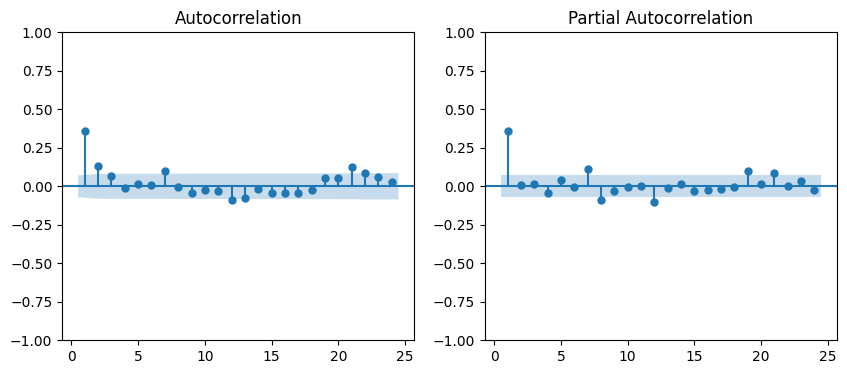

In [794]:
model = LinearRegression(fit_intercept=False)
_ = model.fit(det_proc.in_sample(), df['NumVehicles'])
resid = df['NumVehicles'] -  pd.Series(model.predict(det_proc.in_sample()), index=df.index)
fig, axes = plt.subplots(1, 2, figsize=(10,4))
fig = plot_acf(resid, lags=24, ax=axes[0], zero=False)
fig = plot_pacf(resid, lags=24, ax=axes[1], zero=False)
plt.show()

### Add autoregressive term

In [795]:
mod = SARIMAX(df['NumVehicles'], trend=None, exog=det_proc.in_sample(), order=(1,0,0))
res = mod.fit(disp=False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:            NumVehicles   No. Observations:                  747
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -7462.128
Date:                Mon, 12 Feb 2024   AIC                          14984.256
Time:                        08:01:25   BIC                          15122.738
Sample:                             0   HQIC                         15037.626
                                - 747                                         
Covariance Type:                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           9.571e+04   1122.607     85.259      0.000    9.35e+04    9.79e+04
trend             17.1203      2.252      7.602      0.000      12.706      21.534
s(2,7)         -1.261e+04    793.785

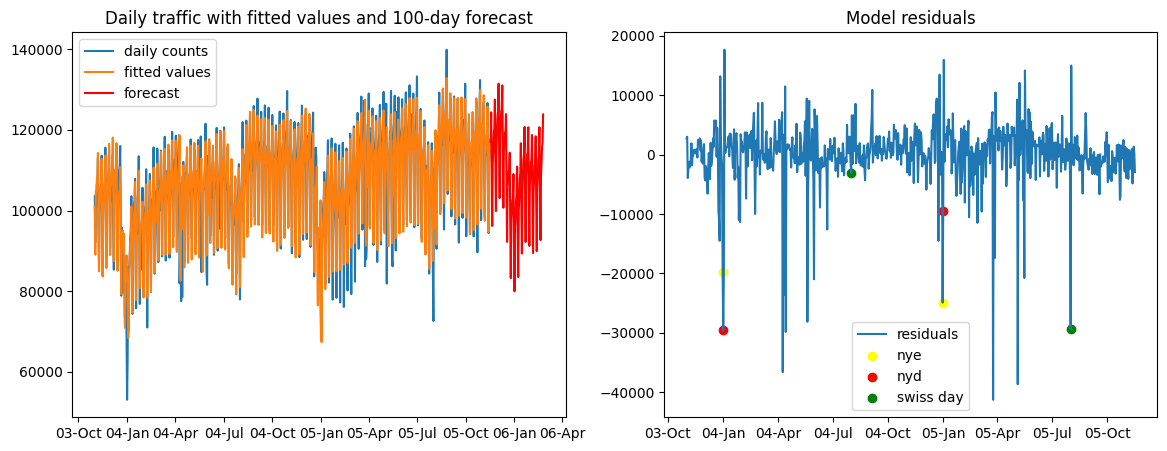

In [796]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14,5))
ax1.plot(df['Day'],df['NumVehicles'], label='daily counts')
ax1.plot(df['Day'],res.fittedvalues, label="fitted values")
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%y-%b'))

forecasted_values = res.forecast(steps=100, exog=det_proc.out_of_sample(100))
ax1.plot(df.Day.iloc[-1] + np.arange(1,101) * np.timedelta64(1, 'D'), forecasted_values, c='red', label="forecast")
ax1.set_title('Daily traffic with fitted values and 100-day forecast')
ax1.legend()

resid = df['NumVehicles'] - res.fittedvalues
ax2.plot(df['Day'], resid, label="residuals")
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%y-%b'))

idx = np.where((df.Day.dt.month == 1) & (df.Day.dt.day == 1))[0]
ax2.scatter(df.loc[idx-1, 'Day'], resid.loc[idx-1], label = 'nye', c = "yellow")
ax2.scatter(df.loc[idx, 'Day'], resid.loc[idx], label = 'nyd', c = "red")
idx = np.where((df.Day.dt.month == 8) & (df.Day.dt.day == 1))[0]
ax2.scatter(df.loc[idx, 'Day'], resid.loc[idx], label = 'swiss day', c = "green")
ax2.set_title('Model residuals')

ax2.legend()
plt.show()

### Hybrid model

1. Fit target with first model
    - model_1.fit(X_train_1, y_train)
    - y_pred_1 = model_1.predict(X_train)<br/><br/>

2. Fit second model on first model residuals
    - model_2.fit(X_train_2, y_train - y_pred_1)
    - y_pred_2 = model_2.predict(X_train_2) <br/><br/>

3. Add the two model outputs to get overall predictions
    - y_pred = y_pred_1 + y_pred_2
  
- Common strategy for constructing hybrid model:
    - a simple (usually linear) learning algorithm
    - followed by a complex, non-linear learner like GBDTs or a deep neural net
    - the simple model typically designed as a "helper" for the powerful algorithm that follows
 
### Note
- Two general ways regression algorithms make predictions:
    1. *Feature-transforming algorithms*
        - learn some mathematical function that takes features as an input and then combines and transforms them to produce an output to matches the target values
        - ex: linear regression and neural nets
        - feature transformers generally can **extrapolate** target values beyond the training set
    3. *Target-transforming algorithms*
        - use the features to group the target values in the training set and make predictions by averaging values in a group
        - features indicate which group to average
        - ex: decision trees and nearest neighbors regression
        - predictions of target transformers will always be **bound within the range of the training set**
        - Decision trees, and their ensemble methods random forests and gradient boosted decision trees, cannot extrapolate trends.
      
### Forecasting
- **forecast origin:** time at which you are making a forecast
    - the last time for which you have training data for the time being predicted.
    - Everything up to the origin can be used as features for the prediction<br/><br/>

- **forecast horizon:** time for which you are making a forecast
    - there may be one or more of time steps in the forecast horizon<br/><br/>

- **lead time** (sometimes called latency): time between the origin and the forecast horizon
    - described by the number of steps from origin to horizon: i.e. "1-step ahead" or "3-step ahead" forecast
    - In practice, it may be necessary for a forecast to begin multiple steps ahead of the origin because of delays in data acquisition or processing.

